In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd
import sounddevice as sd
import wave
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import os

In [2]:
# Set seaborn theme and color palette
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(color_pal)

In [3]:
# Dataset path
dataset_path = "C://Users//Malhan//Downloads//Ravdess Emotional Speech Audio//Audio Dataset"
audio_files = glob(os.path.join(dataset_path, '*/*/*.wav'))

In [4]:
# Exploratory Data Analysis (EDA)
def plot_waveform(signal, title, color):
    plt.figure(figsize=(10, 5))
    plt.plot(signal, color=color)
    plt.title(title)
    plt.show()

In [5]:
# Load the first audio file for EDA
y, sr = librosa.load(audio_files[0])
print(f"Signal Samples: {y[:10]}, Shape of Signal: {y.shape}, Number of Samples: {sr}")


Signal Samples: [ 5.3765390e-08 -2.1233145e-08 -6.0478342e-09  3.8985988e-08
 -7.6543131e-08  1.1907758e-07 -1.6708444e-07  2.2135782e-07
 -2.8319053e-07  3.5470680e-07], Shape of Signal: (72838,), Number of Samples: 22050


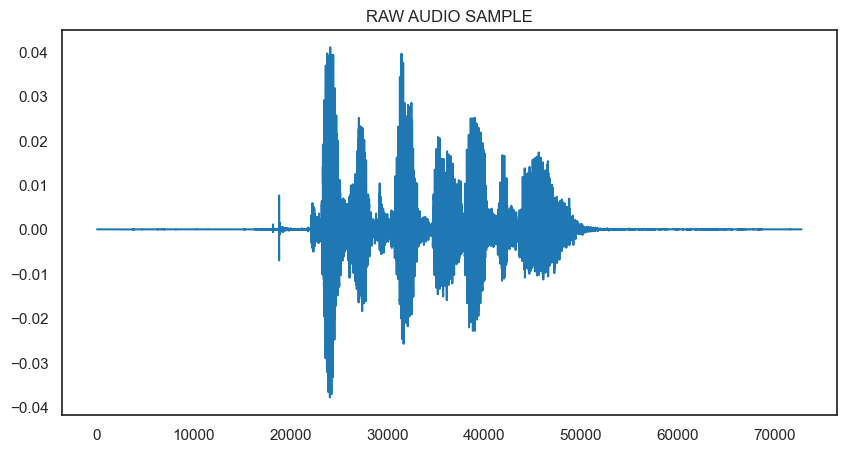

In [6]:
# Plot raw audio
plot_waveform(y, "RAW AUDIO SAMPLE", color_pal[0])

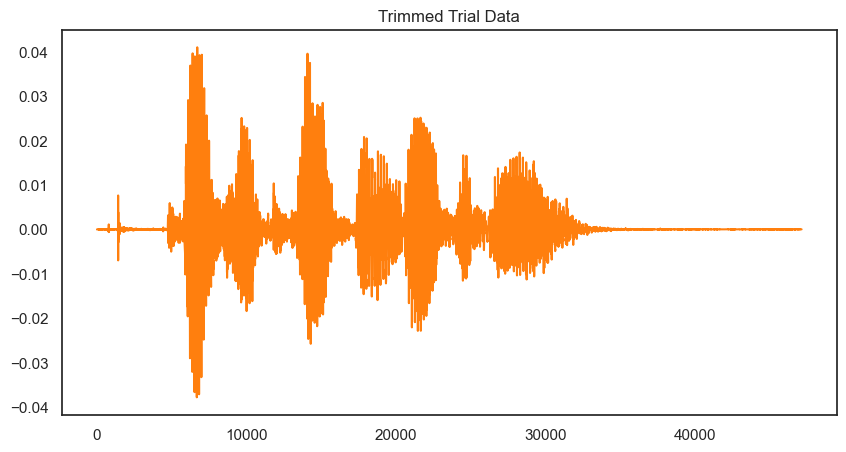

In [7]:
# Trim the audio signal
y_trimmed_trial, _ = librosa.effects.trim(y)
plot_waveform(y_trimmed_trial, "Trimmed Trial Data", color_pal[1])

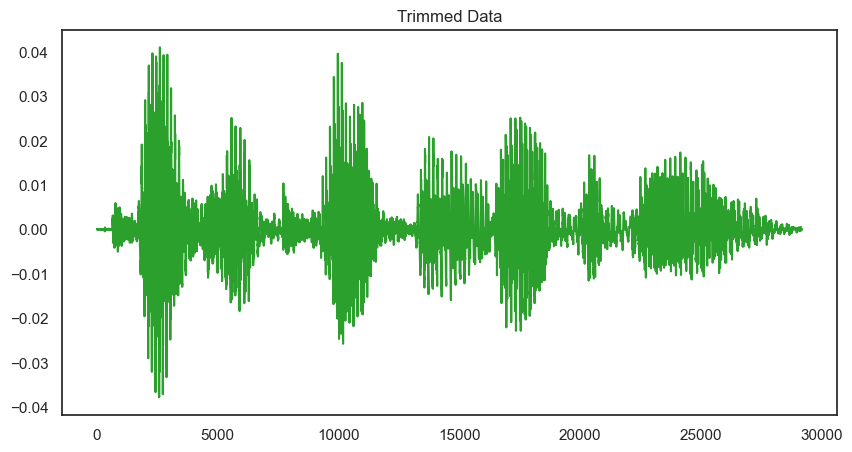

In [8]:
# Trim with a specific top_db
y_trimmed, _ = librosa.effects.trim(y, top_db=30)
plot_waveform(y_trimmed, "Trimmed Data", color_pal[2])

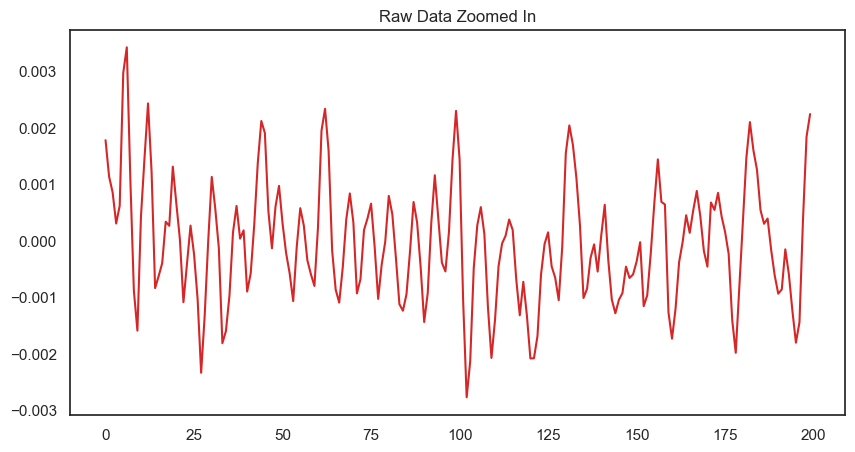

In [9]:
# Zoom into a specific part of the raw data
plot_waveform(y[30000:30200], "Raw Data Zoomed In", color_pal[3])

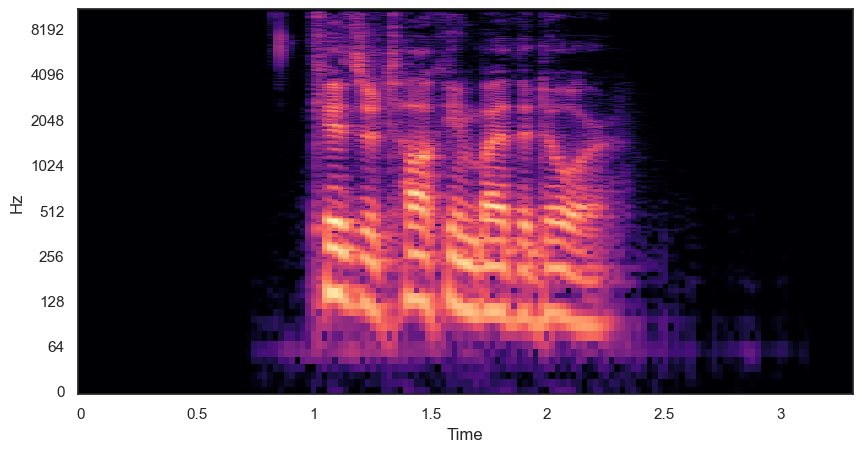

In [10]:
# Spectrogram
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
plt.show()

In [11]:
# Extract emotions from file names
Emotion = {"01": "neutral", "02": "calm", "03": "happy", "04": "sad", "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"}
df = pd.DataFrame(audio_files, columns=["Filename"])
df["feeling"] = [Emotion[file.split("\\")[-1].split("-")[2]] for file in audio_files]


In [12]:
# Feature Extraction
features_list = []
for file in df["Filename"].tolist():
    y, sr = librosa.load(file, sr=None)
    y_trimmed, _ = librosa.effects.trim(y, top_db=30)
    stft = np.abs(librosa.stft(y_trimmed))
    mfccs = np.mean(librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=19).T, axis=0) 
    mel = np.mean(librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=19).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    features = np.hstack((mfccs, mel, chroma))
    features_list.append(features)

# Convert list of features to DataFrame
df2 = pd.DataFrame(features_list)

# Combine features with labels
result_df = pd.concat([df2, df["feeling"]], axis=1)

In [13]:
result_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,feeling
0,-566.207642,144.155685,-0.689935,24.438587,8.682677,26.817156,-9.535861,4.106884,-9.137013,-5.614650,...,0.633390,0.639254,0.601547,0.609249,0.652015,0.714244,0.718476,0.690378,0.616178,neutral
1,-535.216125,152.901596,-2.176142,26.564825,12.252001,28.801764,-15.535562,6.357618,-11.222684,-9.634521,...,0.594463,0.589900,0.619846,0.574901,0.599439,0.659042,0.688037,0.701053,0.653608,neutral
2,-523.600647,157.869156,1.780761,26.070152,10.897964,21.953964,-11.993623,8.234470,-13.447271,-7.850119,...,0.680848,0.623284,0.540795,0.557530,0.641133,0.700230,0.647072,0.588665,0.584085,neutral
3,-519.091309,148.097061,4.148760,30.649202,10.639366,25.031591,-10.647826,9.899387,-15.102771,-8.689160,...,0.633914,0.633912,0.610809,0.624490,0.694990,0.699313,0.651765,0.646385,0.638668,neutral
4,-588.702637,146.859558,3.786862,28.111315,9.126456,26.848070,-10.575955,6.685769,-13.306925,-2.961540,...,0.619960,0.618349,0.620120,0.609774,0.632045,0.674326,0.691772,0.713628,0.631353,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-432.186737,92.972122,-41.363976,6.403593,-29.397135,-7.767248,-29.822140,-6.993943,-31.775902,-16.095341,...,0.408160,0.480345,0.457672,0.480653,0.508671,0.484628,0.476630,0.510881,0.505639,surprised
1436,-414.062744,107.906143,-24.126436,5.101396,-29.548777,-6.539044,-32.368950,-9.451509,-18.924706,-16.336655,...,0.542532,0.526289,0.456142,0.437277,0.460207,0.469271,0.464026,0.493952,0.569236,surprised
1437,-417.774811,101.473396,-37.505394,9.182624,-28.178324,-2.919871,-36.906830,-10.510134,-18.931845,-15.903103,...,0.474553,0.473814,0.499644,0.502182,0.456570,0.495172,0.523106,0.554968,0.577083,surprised
1438,-375.356049,66.563843,-28.338852,20.263840,-23.746668,0.027955,-25.546284,0.685667,-23.488232,-3.502214,...,0.540139,0.586242,0.662092,0.688028,0.569034,0.504596,0.504411,0.499355,0.527803,surprised


In [14]:
# Split data into training and test sets
X = result_df.drop("feeling", axis=1)
y = result_df["feeling"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [15]:
# Normalize X and encode y
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
encoder = LabelEncoder()
y_train_encoded = to_categorical(encoder.fit_transform(y_train))
y_test_encoded = to_categorical(encoder.transform(y_test))

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, GRU, Activation

In [19]:
# Create a Sequential model
model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(50, 1))) 
model.add(LSTM(64, return_sequences=False))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(8))
model.add(Activation('softmax'))

# Optimizer
optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 activation_1 (Activation)   (None, 64)               

In [20]:
# Training without callbacks
history = model.fit(X_train, y_train_encoded, epochs=300, batch_size=64, validation_data=(X_test, y_test_encoded))

Epoch 1/300


21/21 [==============================] - 17s 226ms/step - loss: 2.0730 - accuracy: 0.1381 - val_loss: 2.0319 - val_accuracy: 0.2083
Epoch 2/300
21/21 [==============================] - 3s 152ms/step - loss: 2.0498 - accuracy: 0.1566 - val_loss: 1.9778 - val_accuracy: 0.1944
Epoch 3/300
21/21 [==============================] - 3s 153ms/step - loss: 2.0018 - accuracy: 0.1906 - val_loss: 1.9277 - val_accuracy: 0.1944
Epoch 4/300
21/21 [==============================] - 3s 140ms/step - loss: 1.9776 - accuracy: 0.1960 - val_loss: 1.8942 - val_accuracy: 0.2500
Epoch 5/300
21/21 [==============================] - 2s 90ms/step - loss: 1.9742 - accuracy: 0.2022 - val_loss: 1.9079 - val_accuracy: 0.2153
Epoch 6/300
21/21 [==============================] - 2s 97ms/step - loss: 1.9611 - accuracy: 0.1944 - val_loss: 1.8955 - val_accuracy: 0.2778
Epoch 7/300
21/21 [==============================] - 2s 107ms/step - loss: 1.9819 - accuracy: 0.1867 - val_loss: 1.9174 - val_accuracy: 0.222

In [21]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')

5/5 [==============================] - 0s 22ms/step - loss: 5.6579 - accuracy: 0.5556
Test Accuracy: 0.5556


In [22]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train_encoded)

# Print the training accuracy
print(f'Training Accuracy: {train_accuracy:.4f}')

41/41 [==============================] - 2s 35ms/step - loss: 0.1041 - accuracy: 0.9715
Training Accuracy: 0.9715


In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
train_loss, train_accuracy = model.evaluate(X_train, y_train_encoded)

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

41/41 [==============================] - 1s 12ms/step - loss: 0.1041 - accuracy: 0.9715
Training Accuracy: 0.9715
Test Accuracy: 0.5556


In [27]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
train_loss, train_accuracy = model.evaluate(X_train, y_train_encoded)

# Multiply by 100 to convert to percentage
train_accuracy_percent = train_accuracy * 100
test_accuracy_percent = test_accuracy * 100

print(f'Training Accuracy: {train_accuracy_percent:.2f}%')
print(f'Test Accuracy: {test_accuracy_percent:.2f}%')


41/41 [==============================] - 1s 13ms/step - loss: 0.1041 - accuracy: 0.9715
Training Accuracy: 97.15%
Test Accuracy: 55.56%


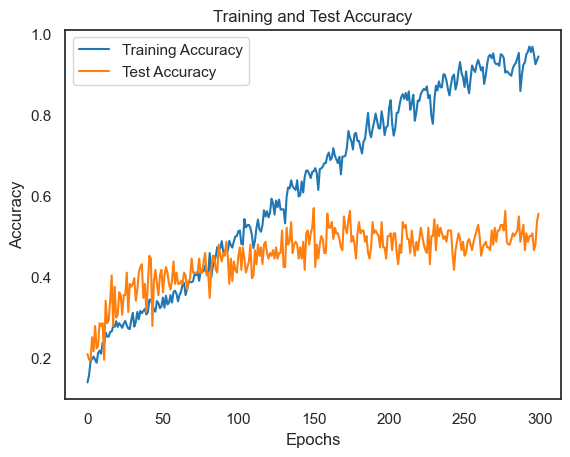

In [23]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')

# Adding title and labels
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Adding legend
plt.legend()

# Display the plot
plt.show()




In [ ]:
model.save("C://Users//Malhan//Downloads//Test Audios//emotion_recognition_model2.h5")